In [3]:
# !pip install torch
# !pip install pandas
# !pip install numpy
# !pip install transformers
# !pip install openpyxl
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install sentencepiece

In [1]:
import os, warnings, torch
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
warnings.filterwarnings('ignore')

data_dir = os.path.join(os.getcwd(), "Dataset")
output_dir = os.path.join(os.getcwd(), "models", "albert-large-v1_v2")

## Read in dataset

In [2]:
processed_df = pd.read_csv(os.path.join(data_dir,"emotions_processed_df.csv"))
processed_df.sample(5)

,sentiment,content
1529,worry,still awake fall asleep one bite sleepy
37839,sadness,become overwhelm feel defeat
25783,love,jmbuckingham time seek coffee caffein love aff...
25512,happiness,lilrainbow89 hi thank follow much long time si...
8036,sadness,even pick npop go dinner ta lum tum tum somtum...


In [3]:
processed_df = processed_df.rename(columns={"sentiment": "labels", "content": "text"})
processed_df.sample(5)

,labels,text
49897,sadness,feel deprive intimacy
45786,happy,feel valuable piece consumer knowledge one ite...
52188,anger,diss bag feel grouchy lack inspiration whatsoe...
7073,worry,mbleah unfortunately
55002,happy,feel though worthwhile career wise


In [4]:
processed_df["labels"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger', 'fear',
       'happy'], dtype=object)

In [5]:
processed_df.isnull().sum()

labels     0
text      15
dtype: int64

In [6]:
processed_df = processed_df.dropna()
processed_df.isnull().sum()

labels    0
text      0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['labels'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [8]:
le = LabelEncoder()
le.fit(processed_df['labels'])
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_name_mapping)

class_name = []

#print both key and value from mapping 
for key, value in le_name_mapping.items():
    print(key, value)
    class_name.append(value)

{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fear', 5: 'fun', 6: 'happiness', 7: 'happy', 8: 'hate', 9: 'love', 10: 'neutral', 11: 'relief', 12: 'sadness', 13: 'worry'}
0 anger
1 boredom
2 empty
3 enthusiasm
4 fear
5 fun
6 happiness
7 happy
8 hate
9 love
10 neutral
11 relief
12 sadness
13 worry


In [9]:
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
from transformers import AlbertTokenizerFast
tokenizer = AlbertTokenizerFast.from_pretrained('albert-large-v1')

In [10]:
#padding and truncation of data
inputs = tokenizer(X_train['text'].tolist(), padding="max_length", truncation=True)

In [12]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = EmotionDataset(inputs, y_train)

## Model Building

In [13]:
num_labels = len(processed_df["labels"].unique())
num_labels

14

In [14]:
from transformers import AlbertForSequenceClassification
model = AlbertForSequenceClassification.from_pretrained('albert-large-v1', num_labels=num_labels)

Some weights of the model checkpoint at albert-large-v1 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You s

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [17]:
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=1024, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_feat

In [18]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=5000,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=5000,              # how often to log
)
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

***** Running training *****
  Num examples = 46702
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17514
  Number of trainable parameters = 17698318


Step,Training Loss
5000,1.905300
10000,2.309000
15000,2.299300


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=17514, training_loss=2.189282948641087, metrics={'train_runtime': 9543.6283, 'train_samples_per_second': 14.681, 'train_steps_per_second': 1.835, 'total_flos': 5936380869906432.0, 'train_loss': 2.189282948641087, 'epoch': 3.0})

In [9]:
# Load a trained model and vocabulary that you have fine-tuned
model_class, tokenizer_class, pretrained_weights = (transformers.AlbertForSequenceClassification, transformers.AlbertTokenizerFast, 'albert-large-v1')

model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Copy the model to the GPU.
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=1024, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_feat

In [10]:
def to_check_result(test_encoding):
    input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
    with torch.no_grad():
        output = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    y = np.argmax(output[0].to("cpu").numpy())
    return y

In [11]:
test_emotions = []
for i in X_test["text"]:
    test_encoding1 = tokenizer(i, padding=True, truncation=True)
    input_ids = torch.tensor(test_encoding1["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding1["attention_mask"]).to(device)
    test_emotions.append(to_check_result(test_encoding1))

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

 Accuracy 0.1939
 Precision 0.0376 
 Recall 0.1939 
 F1 0.063

Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0  635    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   45    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  166    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  159    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  490    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  355    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 1057    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 1423    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  270    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 1112    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 1700    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  315    0]
 [   0    0    0    0    0    0    0    0 

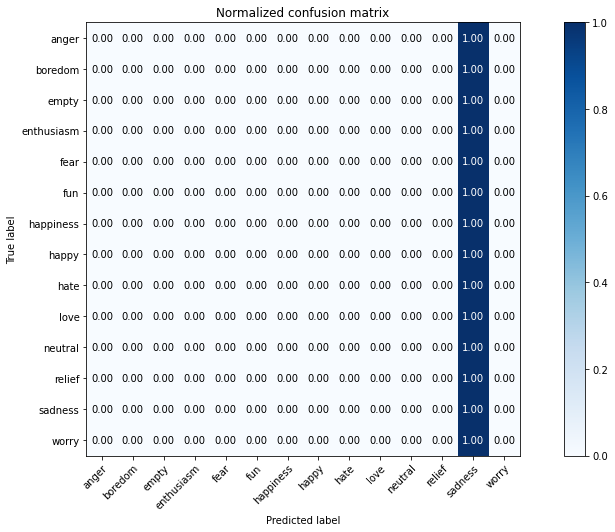

In [13]:
#checking the accuracy of the model
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
acc = round(accuracy_score(y_test, test_emotions),4)
pre = round(precision_score(y_test, test_emotions, average='weighted'),4)
rec = round(recall_score(y_test, test_emotions, average='weighted'),4)
f1 = round(f1_score(y_test, test_emotions, average='weighted'),4)

print(" Accuracy", acc)
print(" Precision",pre,"\n","Recall",rec,"\n","F1",f1)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_emotions))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_emotions, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [22]:
model_dir = 'albert-large-v1/'
output_dir = './model_save/'+model_dir

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Configuration saved in ./model_save/albert-large-v1/config.json
Model weights saved in ./model_save/albert-large-v1/pytorch_model.bin
tokenizer config file saved in ./model_save/albert-large-v1/tokenizer_config.json
Special tokens file saved in ./model_save/albert-large-v1/special_tokens_map.json


Saving model to ./model_save/albert-large-v1/


('./model_save/albert-large-v1/tokenizer_config.json',
 './model_save/albert-large-v1/special_tokens_map.json',
 './model_save/albert-large-v1/spiece.model',
 './model_save/albert-large-v1/added_tokens.json',
 './model_save/albert-large-v1/tokenizer.json')

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

21